In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2


Text(0.5, 1.0, 'Input Image')

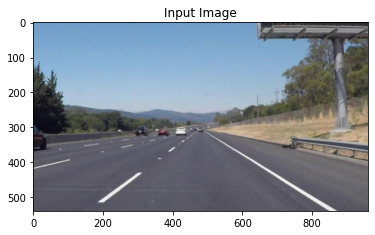

In [2]:
input_image = mpimg.imread("dataset/test-image.jpg")

plt.imshow(input_image)
plt.title("Input Image")


Text(0.5, 1.0, 'Grayscaled Image')

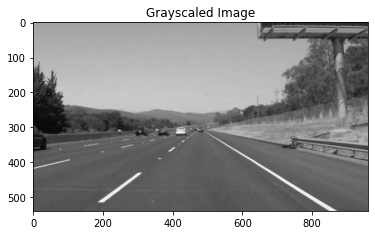

In [3]:
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray")
plt.title("Grayscaled Image")


Text(0.5, 1.0, 'Noise-reduced Image')

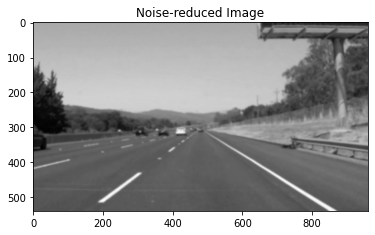

In [4]:
noise_reduction_kernel_size = 9

noiseless_image = cv2.GaussianBlur(
    gray_image, (noise_reduction_kernel_size, noise_reduction_kernel_size), 0
)

plt.imshow(noiseless_image, cmap="gray")
plt.title("Noise-reduced Image")


Text(0.5, 1.0, 'Edges Image')

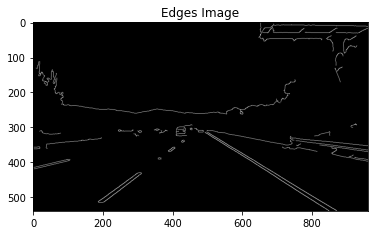

In [5]:
canny_hysteresis_min_val = 60
canny_hysteresis_max_val = 150

edges_image = cv2.Canny(
    noiseless_image, canny_hysteresis_min_val, canny_hysteresis_max_val
)

implot = plt.imshow(edges_image, cmap="gray")
plt.title("Edges Image")


Text(0.5, 1.0, 'Region of Interest Mask')

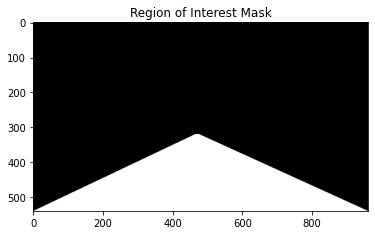

In [6]:
region_of_interest_mask = np.zeros_like(edges_image)
region_of_interest_mask_vertices = np.array(
    [
        [
            (0, input_image.shape[0]),
            (465, 320),
            (475, 320),
            (input_image.shape[1], input_image.shape[0]),
        ]
    ],
    dtype=np.int32,
)
region_of_interest_mask_color = 255

cv2.fillPoly(
    region_of_interest_mask,
    region_of_interest_mask_vertices,
    region_of_interest_mask_color,
)

plt.imshow(region_of_interest_mask, cmap="gray")
plt.title("Region of Interest Mask")


Text(0.5, 1.0, 'Masked Edges Image')

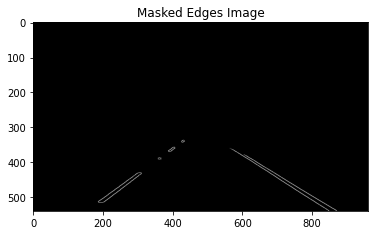

In [7]:
masked_edges_image = cv2.bitwise_and(edges_image, region_of_interest_mask)

plt.imshow(masked_edges_image, cmap="gray")
plt.title("Masked Edges Image")


Text(0.5, 1.0, 'Hough Lines')

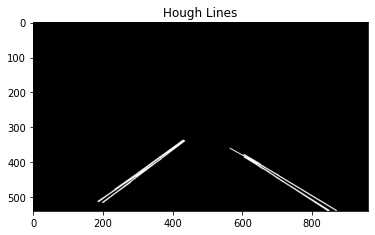

In [8]:
hough_rho = 2
hough_theta = np.pi / 180
hough_threshold = 45
hough_min_line_len = 40
hough_max_line_gap = 100

hough_lines = cv2.HoughLinesP(
    masked_edges_image,
    hough_rho,
    hough_theta,
    hough_threshold,
    np.array([]),
    minLineLength=hough_min_line_len,
    maxLineGap=hough_max_line_gap,
)

hough_lines_image = np.zeros_like(masked_edges_image)
for i in range(len(hough_lines)):
    for x1, y1, x2, y2 in hough_lines[i]:
        cv2.line(hough_lines_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

plt.imshow(hough_lines_image, cmap="gray")
plt.title("Hough Lines")


In [9]:
def calculate_line_coordinates(line_parameters):
    slope, intercept = line_parameters
    y1 = input_image.shape[0]
    y2 = int(y1 - 200)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


left_lines = []
right_lines = []

for line in hough_lines:
    x1, y1, x2, y2 = line.reshape(4)
    line_parameters = np.polyfit((x1, x2), (y1, y2), 1)
    slope = line_parameters[0]
    y_intercept = line_parameters[1]
    if slope < 0:
        left_lines.append((slope, y_intercept))
    else:
        right_lines.append((slope, y_intercept))

left_lines_mean = np.average(left_lines, axis=0)
right_lines_mean = np.average(right_lines, axis=0)

left_lane = calculate_line_coordinates(left_lines_mean)
right_lane = calculate_line_coordinates(right_lines_mean)


Text(0.5, 1.0, 'Lane Fill Image')

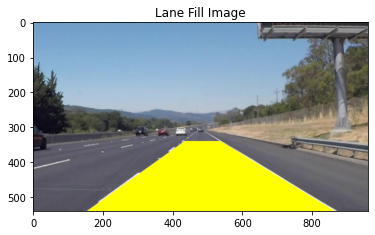

In [10]:
lane_fill_image = input_image.copy()
lane_fill_vertices = np.array(
    [
        [
            (left_lane[0], left_lane[1]),
            (left_lane[2], left_lane[3]),
            (right_lane[2], right_lane[3]),
            (right_lane[0], right_lane[1]),
        ]
    ],
    dtype=np.int32,
)
lane_fill_color = [255, 255, 0]

cv2.fillPoly(lane_fill_image, lane_fill_vertices, lane_fill_color)

plt.imshow(lane_fill_image)
plt.title("Lane Fill Image")


Text(0.5, 1.0, 'Output Image')

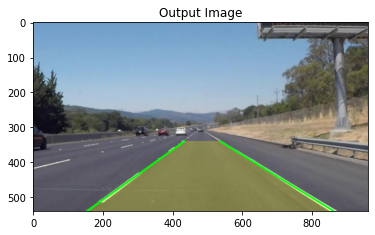

In [11]:
blend_opacity = 0.25

output_image = cv2.addWeighted(
    lane_fill_image, blend_opacity, input_image, 1 - blend_opacity, 0, input_image
)

cv2.line(
    output_image,
    (left_lane[0], left_lane[1]),
    (left_lane[2], left_lane[3]),
    (0, 255, 0),
    4,
)
cv2.line(
    output_image,
    (right_lane[0], right_lane[1]),
    (right_lane[2], right_lane[3]),
    (0, 255, 0),
    4,
)

plt.imshow(output_image)
plt.title("Output Image")
